# Import Library

In [1]:
import os
import cv2
import numpy as np
import keras
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

# Konstanta
TRAIN_PATH = r"D:\Kuliah Praktik\robot sosial\arm robot\dataset\Train"
TEST_PATH = r"D:\Kuliah Praktik\robot sosial\arm robot\dataset\Test"
IMAGE_WIDTH, IMAGE_HEIGHT = 150, 150
NUM_CHANNELS = 3
BATCH_SIZE = 32
EPOCHS = 10
MODEL_PATH = "cnn_color_classification.h5"

# Pastikan dataset tersedia
if not os.path.exists(TRAIN_PATH) or not os.path.exists(TEST_PATH):
    raise ValueError("Dataset path is incorrect or missing.")


# Load Dataset

In [2]:
def load_data_from_directory(directory, image_size):
    X = []
    y = []
    class_names = sorted(class_name for class_name in os.listdir(directory))
    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            image = cv2.imread(image_path)
            if image is None:
                print(f"Warning: Unable to read {image_path}. Skipping...")
                continue
            image = cv2.resize(image, image_size)
            X.append(image)
            y.append(class_names.index(class_name))
    return np.array(X), np.array(y), class_names



# prepocessing Data

In [3]:
# Load dan preprocess dataset
X_train, y_train, class_names = load_data_from_directory(TRAIN_PATH, (IMAGE_WIDTH, IMAGE_HEIGHT))
X_test, y_test, _ = load_data_from_directory(TEST_PATH, (IMAGE_WIDTH, IMAGE_HEIGHT))

In [4]:
# Normalize the images
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [5]:
# Ensure valid labels for one-hot encoding
jumlah_kelas = len(class_names)
y_train = to_categorical(y_train, num_classes=jumlah_kelas)
y_test = to_categorical(y_test, num_classes=jumlah_kelas)

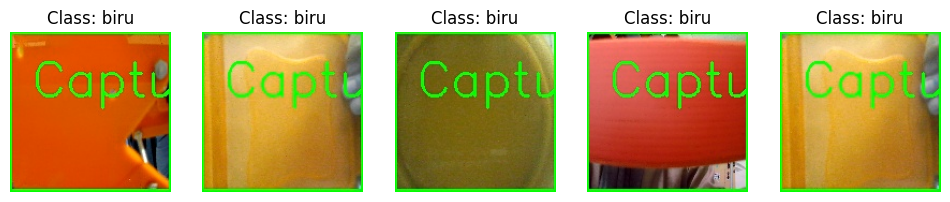

In [6]:
def plot_sample_images(X, y, class_names, num_samples=5):
    plt.figure(figsize=(12, 6))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(X[i])
        plt.title(f"Class: {class_names[np.argmax(y[i])]}")
        plt.axis("off")
    plt.show()

# Tampilkan contoh gambar dari dataset
plot_sample_images(X_train, y_train, class_names)


# Model CNN

In [34]:
# Create CNN model
model = Sequential()

# Add convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUM_CHANNELS)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output from convolutional layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(jumlah_kelas, activation='softmax'))


# Kompilasi model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [9]:
# Data augmentation
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
                             shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
datagen.fit(X_train)


# Train Model

In [10]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss", mode="min")
# Train model
history = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE), 
                    steps_per_epoch=len(X_train) // BATCH_SIZE,
                    epochs=EPOCHS, validation_data=(X_test, y_test))

Epoch 1/10


24/24 [==============================] - 70s 2s/step - loss: 0.6152 - accuracy: 0.7562 - val_loss: 0.1433 - val_accuracy: 0.9374
Epoch 2/10
24/24 [==============================] - 35s 1s/step - loss: 0.1107 - accuracy: 0.9648 - val_loss: 0.0078 - val_accuracy: 0.9987
Epoch 3/10
24/24 [==============================] - 34s 1s/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 0.9987
Epoch 4/10
24/24 [==============================] - 33s 1s/step - loss: 0.0073 - accuracy: 0.9974 - val_loss: 5.7060e-04 - val_accuracy: 1.0000
Epoch 5/10
24/24 [==============================] - 33s 1s/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 7.8378e-05 - val_accuracy: 1.0000
Epoch 6/10
24/24 [==============================] - 36s 1s/step - loss: 0.0078 - accuracy: 0.9987 - val_loss: 3.6247e-04 - val_accuracy: 1.0000
Epoch 7/10
24/24 [==============================] - 35s 1s/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 1.0750e-04 - val_accuracy: 1.0000
Ep

# Evaluate Model and Predict

In [31]:
# Evaluate model on test data
accuracy = model.evaluate(X_test, y_test)[1]
print("Accuracy on test data: {:.2f}%".format(accuracy * 100))


25/25 [==============================] - 7s 265ms/step - loss: 1.0117e-05 - accuracy: 1.0000
Accuracy on test data: 100.00%


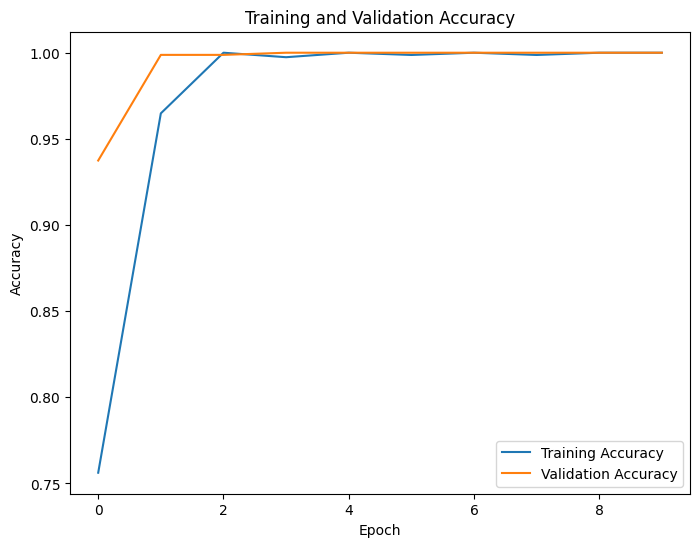

In [32]:
# Plot training history
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

25/25 [==============================] - 7s 248ms/step
Accuracy for class 'biru': 100.00%
Accuracy for class 'hitam': 100.00%
Accuracy for class 'kuning': 100.00%
Accuracy for class 'merah': 100.00%


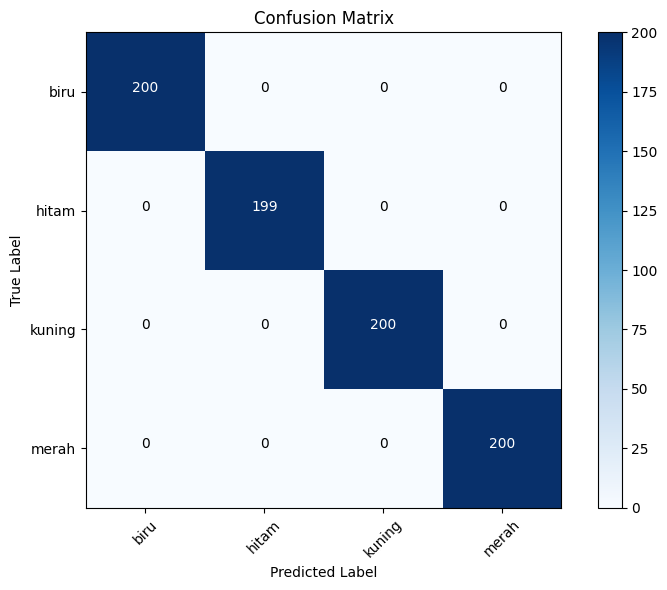

In [28]:
# Predict class probabilities for test data
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Convert one-hot encoded labels back to numeric labels
y_test_numeric = np.argmax(y_test, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(y_test_numeric, y_pred)

# Calculate the accuracy for each class
class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Print accuracy per class
for i, class_name in enumerate(class_names):
    print(f"Accuracy for class '{class_name}': {class_accuracies[i] * 100:.2f}%")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')  

# Display confusion matrix values on the plot
thresh = conf_matrix.max() / 2.
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

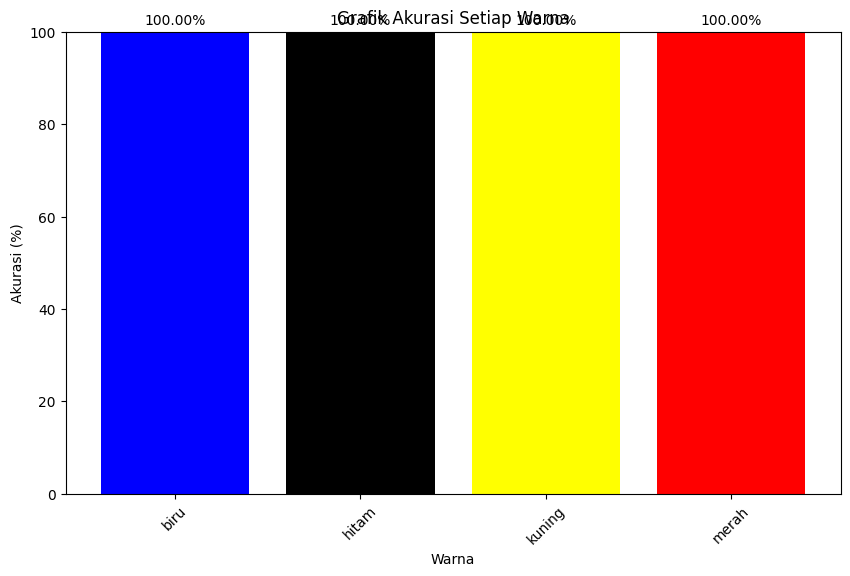

In [14]:
# Hitung akurasi per kelas
class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Plot grafik akurasi setiap warna
plt.figure(figsize=(10, 6))
bars = plt.bar(class_names, class_accuracies * 100, color=['blue', 'black', 'yellow', 'red'][:len(class_names)])
plt.title('Grafik Akurasi Setiap Warna')
plt.xlabel('Warna')
plt.ylabel('Akurasi (%)')
plt.ylim(0, 100)
plt.xticks(rotation=45)

# Annotasi tiap bar dengan persentase akurasi
for bar, accuracy in zip(bars, class_accuracies * 100):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f"{accuracy:.2f}%", ha='center', va='bottom')

plt.show()


In [29]:
# Save the trained model
model.save(r"D:\Kuliah Praktik\robot sosial\arm robot\cnn_arm_robot_model(1).h5")
print("Model has been saved.")

C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model has been saved.
